In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm
from scipy.stats import mannwhitneyu

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(0)



blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

In [2]:
from src.model import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices
from network_parameters import network_parameters

In [3]:
recording_parameters = {}
recording_parameters["regions"] = ["mtl_sparse", "mtl_dense", "ctx"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = []
recording_parameters["rate_connectivity"] = np.inf


input_params = {}
input_params["num_days"] = 1000
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

In [4]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [5]:
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [6]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=5)

In [7]:
torch.save(network, "checkpoints/network_3_A.pt")
network = torch.load("checkpoints/network_3_A.pt", weights_only=False)

In [8]:
ctx_random = torch.randn(network.ctx_size)
ctx = network.pattern_complete('ctx', h_0=ctx_random, subregion_index=0, sleep=True)

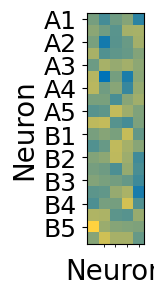

In [9]:
fig = plt.figure(figsize=(3, 3))


plt.imshow(ctx_random[network.ordered_indices_ctx][:100].reshape(-1, 5), cmap=blue_yellow)

# Example parameters
N = 20  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Neuron", fontsize=20)
plt.xticks([])
plt.xticks(np.arange(1, 5, 1), minor=True)


plt.savefig('Figures_SVG/3b1.svg', dpi=300, transparent=True)

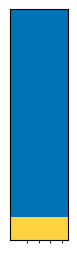

In [10]:
fig = plt.figure(figsize=(3, 3))


plt.imshow(ctx[network.ordered_indices_ctx][:100].reshape(-1, 5), cmap=blue_yellow)


plt.yticks([])
plt.xticks([])
plt.xticks(np.arange(1, 5, 1), minor=True)


plt.savefig('Figures_SVG/3b2.svg', dpi=300, transparent=True)

In [11]:
input_params = {}
input_params["num_days"] = 500
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50
100
150
200
250
300
350
400
450


In [12]:
torch.save(network, "checkpoints/network_3_B.pt")
network = torch.load("checkpoints/network_3_B.pt", weights_only=False)

In [13]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)

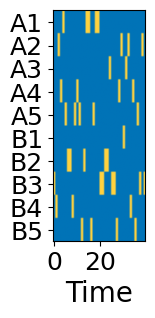

In [14]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_B][-input_params["day_length"]:][:, network.ordered_indices_ctx[:100]].reshape(-1, 100).T, cmap=blue_yellow)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/3b3.svg', dpi=300, transparent=True)

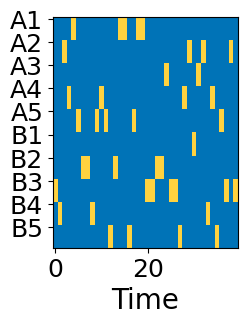

In [15]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.sleep_indices_B][-input_params["day_length"]:][:, network.ordered_indices_mtl_sparse[:100]][:, :50].reshape(-1, 50).T, cmap=blue_yellow)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)

# Example parameters
N = 50  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/3b4.svg', dpi=300, transparent=True)

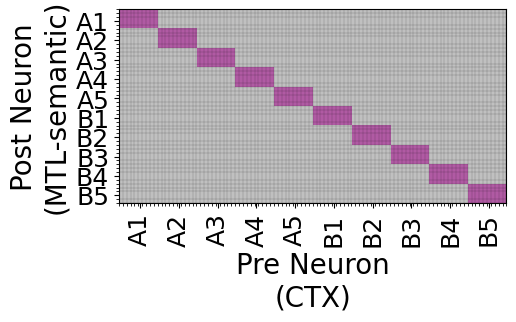

In [16]:
fig = plt.figure(figsize=(5, 3))

plt.imshow(network.mtl_sparse_ctx[network.ordered_indices_mtl_sparse[:50]][:,network.ordered_indices_ctx[:100]], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 50, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions_x = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 50  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions_y = [M * (i + 0.5) for i in range(NA + NB)]


positions_y = [M * (i + 0.5) for i in range(NA + NB)]
plt.xticks(positions_x, labels,  fontsize=18, rotation=90)
plt.yticks(positions_y, labels, fontsize=18)
plt.ylabel("Post Neuron\n(MTL-semantic)", fontsize=20)
plt.xlabel("Pre Neuron\n(CTX)", fontsize=20)
plt.savefig('Figures_SVG/3c.svg', dpi=300, transparent=True)

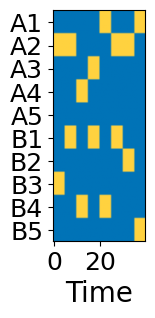

In [17]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-input_params["day_length"]:][:, network.ordered_indices_ctx[:100]].reshape(-1, 100).T, cmap=blue_yellow)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i+0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/3d1.svg', dpi=300, transparent=True)

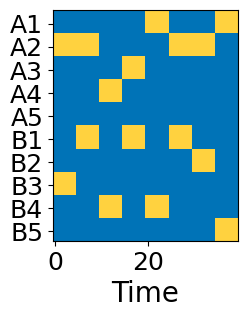

In [18]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-input_params["day_length"]:][:, network.ordered_indices_mtl_sparse[:50]].reshape(-1, 50).T, cmap=blue_yellow)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)

# Example parameters
N = 50  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i+0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/3d2.svg', dpi=300, transparent=True)

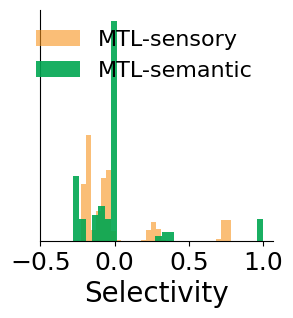

In [19]:
fig = plt.figure(figsize=(3, 3))
plt.hist(network.selectivity_mtl_dense.flatten(), bins=30, label="MTL-sensory", alpha=0.6, color=orange)
plt.hist(network.selectivity_mtl_sparse.flatten(), bins=30, label="MTL-semantic", alpha=0.9, color=green)
plt.xlabel('Selectivity', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.yticks([])
plt.legend(fontsize=16, frameon=False)
plt.savefig('Figures_SVG/3e.svg', dpi=300, transparent=True)

In [20]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [21]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=False, print_rate=50)



X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)

# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

# Create a simple linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        #return F.softmax(self.linear(x), dim=1)
        return self.linear(x)
    

def dual_task_cross_entropy(output, targets):
    """
    output: Tensor of shape (batch_size, 10)
    target_A: Tensor of shape (batch_size,) with values in [0, 4]
    target_B: Tensor of shape (batch_size,) with values in [0, 4]
    """
    logits_A = output[:, :5]   # First 5 neurons
    logits_B = output[:, 5:]   # Last 5 neurons

    loss_A = F.cross_entropy(logits_A, targets[:, 0])
    loss_B = F.cross_entropy(logits_B, targets[:, 1])

    return loss_A + loss_B

def train_model(state_dicts, train_loader, X_test, Y_test, num_trials, num_epochs):

  trials_accuracy = torch.zeros((num_trials, num_epochs, 2))
  trained_state_dicts = []


  for trial in range(num_trials):
    input_size = 100
    num_classes = 10
    model = LinearClassifier(input_size, num_classes)
    model.load_state_dict(state_dicts[trial])

    optimizer = optim.SGD(model.parameters(), lr=10)

    eval_acc = []
    for epoch in range(num_epochs):
        #if epoch%50 == 0:
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = dual_task_cross_entropy(outputs, labels.long())
            loss.backward()
            optimizer.step()

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            predicted = torch.max(test_outputs[:, :5], 1)[1], torch.max(test_outputs[:, 5:], 1)[1]                         
            accuracy_0 = accuracy_score(Y_test[:, 0].numpy(), predicted[0].numpy())
            accuracy_1 = accuracy_score(Y_test[:, 1].numpy(), predicted[1].numpy())
            eval_acc.append((accuracy_0, accuracy_1))
    trials_accuracy[trial] = torch.tensor(eval_acc)
    trained_state_dicts.append(deepcopy(model.state_dict()))
  return trials_accuracy, trained_state_dicts


def test_model(state_dicts, X_test, Y_test):
  input_size = 100
  num_classes = 10
  trials_accuracy = torch.zeros((len(state_dicts), 2))
  for trial, state_dict in enumerate(state_dicts):
    model = LinearClassifier(input_size, num_classes)
    model.load_state_dict(state_dict)
    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        predicted = torch.max(test_outputs[:, :5], 1)[1], torch.max(test_outputs[:, 5:], 1)[1]                         
        accuracy_0 = accuracy_score(Y_test[:, 0].numpy(), predicted[0].numpy())
        accuracy_1 = accuracy_score(Y_test[:, 1].numpy(), predicted[1].numpy())
        trials_accuracy[trial] = torch.tensor((accuracy_0, accuracy_1))
    return trials_accuracy
  


num_trials = 50
num_epochs = 1

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense, models_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse, models_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent, models_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)


0
50


MTL-sensory vs MTL-semantic: p = 0.0000, ***
MTL-sensory vs labels:       p = 0.0000, ***
MTL-semantic vs labels:      p = 0.0729, ns


/tmp/ipykernel_2881033/1264796115.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.4, palette=palette)


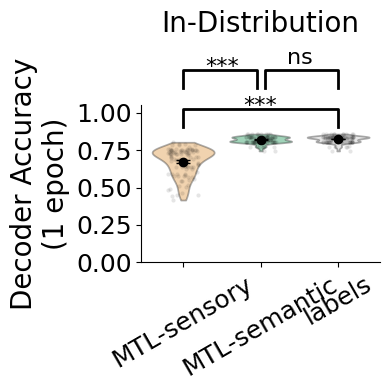

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem

# Flatten your arrays
dense_vals = acc_mtl_dense[:, -1, :].flatten()
sparse_vals = acc_mtl_sparse[:, -1, :].flatten()
latent_vals = acc_latent[:, -1, :].flatten()

# Combine data
data = np.concatenate([dense_vals, sparse_vals, latent_vals])
groups = (['MTL-sensory'] * len(dense_vals) + 
          ['MTL-semantic'] * len(sparse_vals) + 
          ['labels'] * len(latent_vals))

palette = {
    "MTL-sensory": orange,   
    "MTL-semantic": green,  
    "labels": gray      
}

# Create plot
plt.figure(figsize=(4, 4))
plt.title("In-Distribution\n\n", fontsize=20)

# Violin plot
sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.4, palette=palette)

# Strip plot
sns.stripplot(x=groups, y=data, color='k', alpha=0.1, jitter=0.2, size=3)

# Compute mean and SEM per group
group_labels = ['MTL-sensory', 'MTL-semantic', 'labels']
means = [torch.mean(vals) for vals in [dense_vals, sparse_vals, latent_vals]]
sems = [sem(vals) for vals in [dense_vals, sparse_vals, latent_vals]]

# Overlay mean and error bars
x_positions = range(len(group_labels))
plt.errorbar(x_positions, means, yerr=sems, fmt='o', color='black', capsize=5, markersize=6, lw=2, zorder=10)

# Axis formatting
plt.ylabel("Decoder Accuracy\n(1 epoch)", fontsize=20)
plt.xticks(ticks=x_positions, labels=group_labels, fontsize=18, rotation=30)
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=18)
plt.ylim([0.0, 1.05])
plt.tight_layout()
sns.despine()

# Compute the average decoder accuracy across tasks A and B
acc_dense_vals = acc_mtl_dense[:, -1, :].mean(dim=1).numpy()
acc_sparse_vals = acc_mtl_sparse[:, -1, :].mean(dim=1).numpy()
acc_latent_vals = acc_latent[:, -1, :].mean(dim=1).numpy()

# Define significance mapping
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# Compute p-values
p_ds = mannwhitneyu(acc_dense_vals, acc_sparse_vals, alternative='two-sided').pvalue
p_dl = mannwhitneyu(acc_dense_vals, acc_latent_vals, alternative='two-sided').pvalue
p_sl = mannwhitneyu(acc_sparse_vals, acc_latent_vals, alternative='two-sided').pvalue

# Print results
print(f"MTL-sensory vs MTL-semantic: p = {p_ds:.4f}, {p_to_star(p_ds)}")
print(f"MTL-sensory vs labels:       p = {p_dl:.4f}, {p_to_star(p_dl)}")
print(f"MTL-semantic vs labels:      p = {p_sl:.4f}, {p_to_star(p_sl)}")



y_max = max([m + s for m, s in zip(means, sems)]) + 0.08
short_bar = 0.12
tall_bar = 0.14
bar_kwargs = dict(clip_on=False, color='black', linewidth=2)

# Lower bar: (0-2)
y1 = y_max
plt.plot([0, 0, 2, 2], [y1, y1+short_bar, y1+short_bar, y1], **bar_kwargs)
plt.text(1.0, y1+short_bar - 0.05, p_to_star(p_dl), ha='center', va='bottom', fontsize=16)

# Higher bars: (0-1) and (1-2), both at same higher y
y2 = y1 + short_bar + tall_bar
plt.plot([0, 0, 0.95, 0.95], [y2, y2+short_bar, y2+short_bar, y2], **bar_kwargs)
plt.text(0.5, y2+short_bar - 0.05, p_to_star(p_ds), ha='center', va='bottom', fontsize=16)

plt.plot([1.05, 1.05, 2, 2], [y2, y2+short_bar, y2+short_bar, y2], **bar_kwargs)
plt.text(1.5, y2+short_bar+0.01, p_to_star(p_sl), ha='center', va='bottom', fontsize=16)
# Save
plt.savefig('Figures_SVG/3g1.svg', dpi=300, transparent=True)

In [23]:
input_params["num_days"] = 1500
latent_specs["prob_list"] = [0 if i==j else 1/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [24]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
latent_specs["prob_list"] = [1/5 if i==j else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, sleep=False, print_rate=50)


X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)

# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

# Create a simple linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)
    

def dual_task_cross_entropy(output, targets):
    """
    output: Tensor of shape (batch_size, 10)
    target_A: Tensor of shape (batch_size,) with values in [0, 4]
    target_B: Tensor of shape (batch_size,) with values in [0, 4]
    """
    logits_A = output[:, :5]   # First 5 neurons
    logits_B = output[:, 5:]   # Last 5 neurons

    loss_A = F.cross_entropy(logits_A, targets[:, 0])
    loss_B = F.cross_entropy(logits_B, targets[:, 1])

    return loss_A + loss_B

def train_model(state_dicts, train_loader, X_test, Y_test, num_trials, num_epochs):

  trials_accuracy = torch.zeros((num_trials, num_epochs, 2))
  trained_state_dicts = []


  for trial in range(num_trials):
    input_size = 100
    num_classes = 10
    model = LinearClassifier(input_size, num_classes)
    model.load_state_dict(state_dicts[trial])

    optimizer = optim.SGD(model.parameters(), lr=10)

    eval_acc = []
    for epoch in range(num_epochs):
        #if epoch%50 == 0:
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = dual_task_cross_entropy(outputs, labels.long())
            loss.backward()
            optimizer.step()

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            predicted = torch.max(test_outputs[:, :5], 1)[1], torch.max(test_outputs[:, 5:], 1)[1]                         
            accuracy_0 = accuracy_score(Y_test[:, 0].numpy(), predicted[0].numpy())
            accuracy_1 = accuracy_score(Y_test[:, 1].numpy(), predicted[1].numpy())
            eval_acc.append((accuracy_0, accuracy_1))
    trials_accuracy[trial] = torch.tensor(eval_acc)
    trained_state_dicts.append(deepcopy(model.state_dict()))
  return trials_accuracy, trained_state_dicts


def test_model(state_dicts, X_test, Y_test):
  input_size = 100
  num_classes = 10
  trials_accuracy = torch.zeros((len(state_dicts), 2))
  for trial, state_dict in enumerate(state_dicts):
    model = LinearClassifier(input_size, num_classes)
    model.load_state_dict(state_dict)
    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        predicted = torch.max(test_outputs[:, :5], 1)[1], torch.max(test_outputs[:, 5:], 1)[1]                         
        accuracy_0 = accuracy_score(Y_test[:, 0].numpy(), predicted[0].numpy())
        accuracy_1 = accuracy_score(Y_test[:, 1].numpy(), predicted[1].numpy())
        trials_accuracy[trial] = torch.tensor((accuracy_0, accuracy_1))
    return trials_accuracy
  


num_trials = 50
num_epochs = 1

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense, models_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse, models_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent, models_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)


0
50


/tmp/ipykernel_2881033/3703637418.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.4, palette=palette)


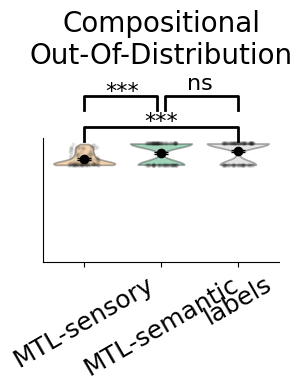

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem

# Flatten your arrays
dense_vals = acc_mtl_dense[:, -1, :].flatten()
sparse_vals = acc_mtl_sparse[:, -1, :].flatten()
latent_vals = acc_latent[:, -1, :].flatten()

# Combine data
data = np.concatenate([dense_vals, sparse_vals, latent_vals])
groups = (['MTL-sensory'] * len(dense_vals) + 
          ['MTL-semantic'] * len(sparse_vals) + 
          ['labels'] * len(latent_vals))

palette = {
    "MTL-sensory": orange,   
    "MTL-semantic": green,  
    "labels": gray      
}

# Create plot
plt.figure(figsize=(3, 4))
plt.title("Compositional\nOut-Of-Distribution\n\n", fontsize=20)

# Violin plot
sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.4, palette=palette)

# Strip plot
sns.stripplot(x=groups, y=data, color='k', alpha=0.1, jitter=0.2, size=3)

# Compute mean and SEM per group
group_labels = ['MTL-sensory', 'MTL-semantic', 'labels']
means = [torch.mean(vals) for vals in [dense_vals, sparse_vals, latent_vals]]
sems = [sem(vals) for vals in [dense_vals, sparse_vals, latent_vals]]

# Overlay mean and error bars
x_positions = range(len(group_labels))
plt.errorbar(x_positions, means, yerr=sems, fmt='o', color='black', capsize=5, markersize=6, lw=2, zorder=10)

# Axis formatting
plt.xticks(ticks=x_positions, labels=group_labels, fontsize=18, rotation=30)
plt.yticks([], fontsize=18)
plt.ylim([0.0, 1.05])
plt.tight_layout()
sns.despine()


# Compute the average decoder accuracy across tasks A and B
acc_dense_vals = acc_mtl_dense[:, -1, :].mean(dim=1).numpy()
acc_sparse_vals = acc_mtl_sparse[:, -1, :].mean(dim=1).numpy()
acc_latent_vals = acc_latent[:, -1, :].mean(dim=1).numpy()

# Define significance mapping
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# Compute p-values
p_ds = mannwhitneyu(acc_dense_vals, acc_sparse_vals, alternative='two-sided').pvalue
p_dl = mannwhitneyu(acc_dense_vals, acc_latent_vals, alternative='two-sided').pvalue
p_sl = mannwhitneyu(acc_sparse_vals, acc_latent_vals, alternative='two-sided').pvalue


y_max = max([m + s for m, s in zip(means, sems)]) + 0.08
short_bar = 0.12
tall_bar = 0.14
bar_kwargs = dict(clip_on=False, color='black', linewidth=2)

# Lower bar: (0-2)
y1 = y_max
plt.plot([0, 0, 2, 2], [y1, y1+short_bar, y1+short_bar, y1], **bar_kwargs)
plt.text(1.0, y1+short_bar - 0.05, p_to_star(p_dl), ha='center', va='bottom', fontsize=16)

# Higher bars: (0-1) and (1-2), both at same higher y
y2 = y1 + short_bar + tall_bar
plt.plot([0, 0, 0.95, 0.95], [y2, y2+short_bar, y2+short_bar, y2], **bar_kwargs)
plt.text(0.5, y2+short_bar - 0.05, p_to_star(p_ds), ha='center', va='bottom', fontsize=16)

plt.plot([1.05, 1.05, 2, 2], [y2, y2+short_bar, y2+short_bar, y2], **bar_kwargs)
plt.text(1.5, y2+short_bar+0.01, p_to_star(p_sl), ha='center', va='bottom', fontsize=16)

# Save
plt.savefig('Figures_SVG/3g2.svg', dpi=300, transparent=True)

In [26]:
def test_network_permuted(net, input_params, sleep=False, print_rate=1):
  input, input_episdoes, input_latents = make_input(**input_params)
  permutation = torch.randperm(network.sen_size)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day][:, permutation], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net


network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network_permuted(network, input_params, print_rate=50)




X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.995, random_state=42)

# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

# Create a simple linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)
    

def dual_task_cross_entropy(output, targets):
    """
    output: Tensor of shape (batch_size, 10)
    target_A: Tensor of shape (batch_size,) with values in [0, 4]
    target_B: Tensor of shape (batch_size,) with values in [0, 4]
    """
    logits_A = output[:, :5]   # First 5 neurons
    logits_B = output[:, 5:]   # Last 5 neurons

    loss_A = F.cross_entropy(logits_A, targets[:, 0])
    loss_B = F.cross_entropy(logits_B, targets[:, 1])

    return loss_A + loss_B

def train_model(state_dicts, train_loader, X_test, Y_test, num_trials, num_epochs):

  trials_accuracy = torch.zeros((num_trials, num_epochs, 2))
  trained_state_dicts = []


  for trial in range(num_trials):
    input_size = 100
    num_classes = 10
    model = LinearClassifier(input_size, num_classes)
    model.load_state_dict(state_dicts[trial])

    optimizer = optim.SGD(model.parameters(), lr=10)

    eval_acc = []
    for epoch in range(num_epochs):
        #if epoch%50 == 0:
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = dual_task_cross_entropy(outputs, labels.long())
            loss.backward()
            optimizer.step()

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            predicted = torch.max(test_outputs[:, :5], 1)[1], torch.max(test_outputs[:, 5:], 1)[1]                         
            accuracy_0 = accuracy_score(Y_test[:, 0].numpy(), predicted[0].numpy())
            accuracy_1 = accuracy_score(Y_test[:, 1].numpy(), predicted[1].numpy())
            eval_acc.append((accuracy_0, accuracy_1))
    trials_accuracy[trial] = torch.tensor(eval_acc)
    trained_state_dicts.append(deepcopy(model.state_dict()))
  return trials_accuracy, trained_state_dicts


def test_model(state_dicts, X_test, Y_test):
  input_size = 100
  num_classes = 10
  trials_accuracy = torch.zeros((len(state_dicts), 2))
  for trial, state_dict in enumerate(state_dicts):
    model = LinearClassifier(input_size, num_classes)
    model.load_state_dict(state_dict)
    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        predicted = torch.max(test_outputs[:, :5], 1)[1], torch.max(test_outputs[:, 5:], 1)[1]                         
        accuracy_0 = accuracy_score(Y_test[:, 0].numpy(), predicted[0].numpy())
        accuracy_1 = accuracy_score(Y_test[:, 1].numpy(), predicted[1].numpy())
        trials_accuracy[trial] = torch.tensor((accuracy_0, accuracy_1))
    return trials_accuracy
  


num_trials = 100
num_epochs = 1

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense, models_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse, models_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent, models_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)

0
50


/tmp/ipykernel_2881033/4179321114.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.4, palette=palette)


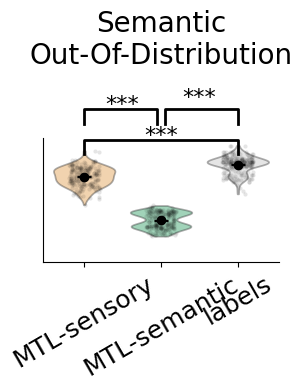

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem

# Flatten your arrays
dense_vals = acc_mtl_dense[:, -1, :].flatten()
sparse_vals = acc_mtl_sparse[:, -1, :].flatten()
latent_vals = acc_latent[:, -1, :].flatten()

# Combine data
data = np.concatenate([dense_vals, sparse_vals, latent_vals])
groups = (['MTL-sensory'] * len(dense_vals) + 
          ['MTL-semantic'] * len(sparse_vals) + 
          ['labels'] * len(latent_vals))

palette = {
    "MTL-sensory": orange,   
    "MTL-semantic": green,  
    "labels": gray      
}

# Create plot
plt.figure(figsize=(3, 4))
plt.title("Semantic\nOut-Of-Distribution\n\n", fontsize=20)

# Violin plot
sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.4, palette=palette)

# Strip plot
sns.stripplot(x=groups, y=data, color='k', alpha=0.1, jitter=0.2, size=3)

# Compute mean and SEM per group
group_labels = ['MTL-sensory', 'MTL-semantic', 'labels']
means = [torch.mean(vals) for vals in [dense_vals, sparse_vals, latent_vals]]
sems = [sem(vals) for vals in [dense_vals, sparse_vals, latent_vals]]

# Overlay mean and error bars
x_positions = range(len(group_labels))
plt.errorbar(x_positions, means, yerr=sems, fmt='o', color='black', capsize=5, markersize=6, lw=2, zorder=10)

# Axis formatting
plt.xticks(ticks=x_positions, labels=group_labels, fontsize=18, rotation=30)
plt.yticks([], fontsize=18)
plt.ylim([0.0, 1.05])
plt.tight_layout()
sns.despine()


# Compute the average decoder accuracy across tasks A and B
acc_dense_vals = acc_mtl_dense[:, -1, :].mean(dim=1).numpy()
acc_sparse_vals = acc_mtl_sparse[:, -1, :].mean(dim=1).numpy()
acc_latent_vals = acc_latent[:, -1, :].mean(dim=1).numpy()

# Define significance mapping
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# Compute p-values
p_ds = mannwhitneyu(acc_dense_vals, acc_sparse_vals, alternative='two-sided').pvalue
p_dl = mannwhitneyu(acc_dense_vals, acc_latent_vals, alternative='two-sided').pvalue
p_sl = mannwhitneyu(acc_sparse_vals, acc_latent_vals, alternative='two-sided').pvalue


y_max = max([m + s for m, s in zip(means, sems)]) + 0.08
short_bar = 0.12
tall_bar = 0.14
bar_kwargs = dict(clip_on=False, color='black', linewidth=2)

# Lower bar: (0-2)
y1 = y_max
plt.plot([0, 0, 2, 2], [y1, y1+short_bar, y1+short_bar, y1], **bar_kwargs)
plt.text(1.0, y1+short_bar - 0.05, p_to_star(p_dl), ha='center', va='bottom', fontsize=16)

# Higher bars: (0-1) and (1-2), both at same higher y
y2 = y1 + short_bar + tall_bar
plt.plot([0, 0, 0.95, 0.95], [y2, y2+short_bar, y2+short_bar, y2], **bar_kwargs)
plt.text(0.5, y2+short_bar - 0.05, p_to_star(p_ds), ha='center', va='bottom', fontsize=16)

plt.plot([1.05, 1.05, 2, 2], [y2, y2+short_bar, y2+short_bar, y2], **bar_kwargs)
plt.text(1.5, y2+short_bar+0.01, p_to_star(p_sl), ha='center', va='bottom', fontsize=16)

# Save
plt.savefig('Figures_SVG/3g3.svg', dpi=300, transparent=True)